# CatBoost

Since Cat Boost performed so well earlier, we will try it again.

In [1]:
import pandas as pd
import joblib
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data_2, evaluate_metrics, plot_roc_curve, optimize_threshold, chosen_columns

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data_2(df)

Once again, we will begin with an untuned model to get some sort of a benchmark.

In [4]:
cat_untuned = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned.fit(X_train, y_train)

y_train_pred = cat_untuned.predict(X_train)
y_test_pred = cat_untuned.predict(X_test)

Training Set Metrics:


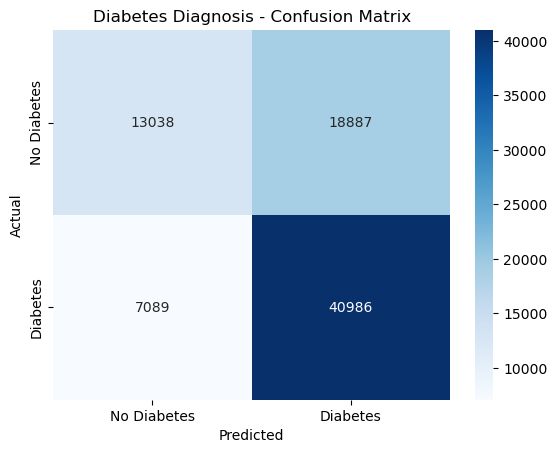

Accuracy: 0.6753
Precision: 0.6845489619695021
Recall: 0.8525429017160686
F1 Score: 0.7593656204839367


Test Set Metrics:


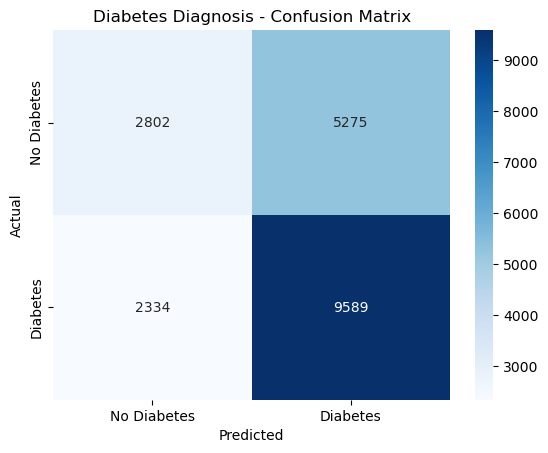

Accuracy: 0.61955
Precision: 0.645115715823466
Recall: 0.8042438983477312
F1 Score: 0.7159443013402024


In [5]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

That is horrible! We will try to find better hyperparameters, but first let's inspect the feature importances.

In [6]:
feature_importances = cat_untuned.get_feature_importance(Pool(X_train, label=y_train))
feature_names = df[chosen_columns].columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                           Feature  Importance
0                          family_history_diabetes   14.853980
3                               waist_to_hip_ratio   12.078027
8                                        age_70-79    3.647581
7                                        age_60-69    3.387241
33       physical_activity_minutes_per_week_Active    2.960143
6                                        age_50-59    2.798753
9                                          age_80+    2.617565
5                                        age_40-49    2.278437
23                       employment_status_Retired    2.258924
34  physical_activity_minutes_per_week_Very Active    2.235281
1                             hypertension_history    1.939350
41                                      bmi_Normal    1.897311
10                                     gender_Male    1.865530
32     physical_activity_minutes_per_week_Moderate    1.833791
4                                        age_30-39    1

family_history_diabetes and waist_to_hip_ratio seem to be more relevant than the others, but not exponentially. A lot of it can be attributed to binning. We will keep all features for now, especially considering how poorly our model performs anyway.

We will now perform a quick search for better parameters.

In [7]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.2, 0.5, 0.8, 1],
    'iterations': [500, 1000, 1500]
}

cbc = CatBoostClassifier(eval_metric='F1', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)
random_search.fit(X_train[:, [4, 6]], y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 10, 'bagging_temperature': 1}


In [8]:
cat_1 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
cat_1.fit(X_train, y_train)

y_train_pred = cat_1.predict(X_train)
y_test_pred = cat_1.predict(X_test)

Training Set Metrics:


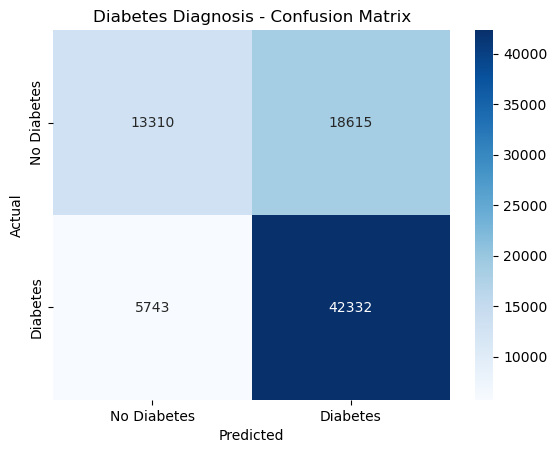

Accuracy: 0.695525
Precision: 0.6945706925689533
Recall: 0.8805408216328653
F1 Score: 0.7765772046009063


Test Set Metrics:


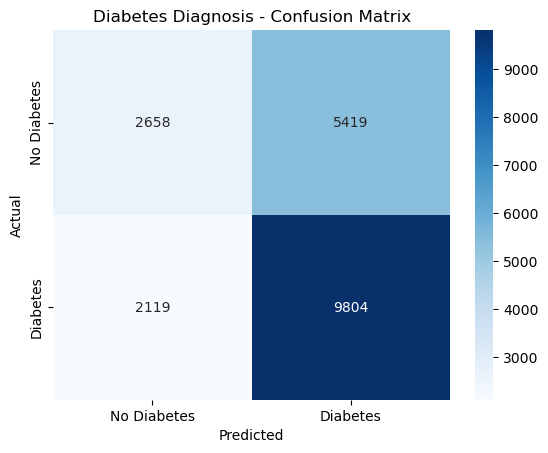

Accuracy: 0.6231
Precision: 0.6440254877488012
Recall: 0.8222762727501468
F1 Score: 0.7223163633684521


In [9]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This did not improve our model by much. We will do another search.

In [10]:
param_dist = {
    'depth': [8, 10, 12, 14],
    'learning_rate': [0.001, 0.005, 0.01, 0.02],
    'l2_leaf_reg': [2, 3, 4],
    'bagging_temperature': [0.9, 1, 1.1, 1.2],
    'iterations': [800, 1000, 1200]
}

cbc = CatBoostClassifier(eval_metric='F1', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)
random_search.fit(X_train[:, [4, 6]], y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.02, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8, 'bagging_temperature': 1.2}


In [11]:
cat_2 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
cat_2.fit(X_train, y_train)

y_train_pred = cat_2.predict(X_train)
y_test_pred = cat_2.predict(X_test)

Training Set Metrics:


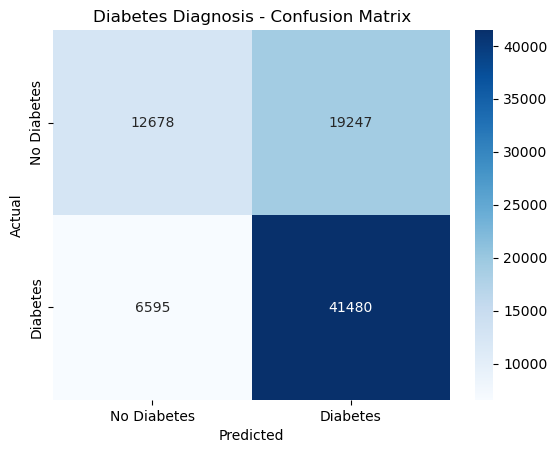

Accuracy: 0.676975
Precision: 0.6830569598366459
Recall: 0.8628185127405096
F1 Score: 0.7624859837135347


Test Set Metrics:


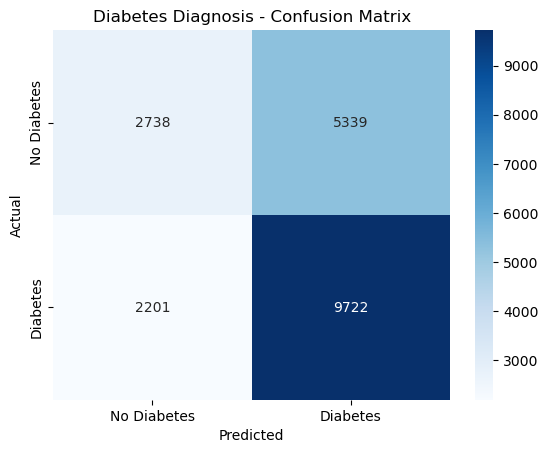

Accuracy: 0.623
Precision: 0.6455082663833743
Recall: 0.8153988090245744
F1 Score: 0.7205751556477913


In [12]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

The model actually got worse, but there is less overfitting. We will perform one more search.

In [13]:
param_dist = {
    'depth': [7, 8, 9],
    'learning_rate': [0.015, 0.02, 0.025, 0.03],
    'l2_leaf_reg': [3],
    'bagging_temperature': [1.2, 1.5, 1.8, 2.0],
    'iterations': [900, 1000, 1100]
}

cbc = CatBoostClassifier(eval_metric='F1', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)
random_search.fit(X_train[:, [4, 6]], y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.025, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 7, 'bagging_temperature': 1.2}


In [14]:
cat_3 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
cat_3.fit(X_train, y_train)

y_train_pred = cat_3.predict(X_train)
y_test_pred = cat_3.predict(X_test)

Training Set Metrics:


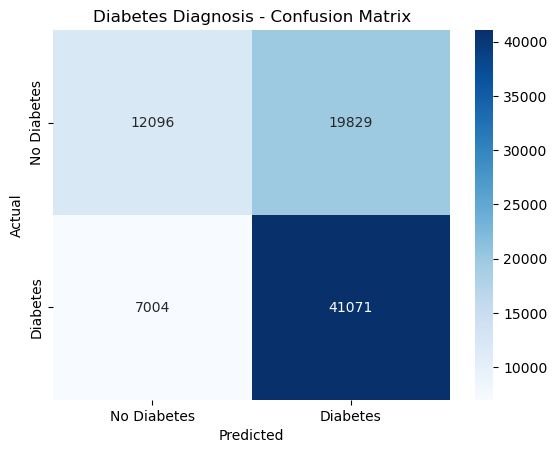

Accuracy: 0.6645875
Precision: 0.6744006568144499
Recall: 0.8543109724388975
F1 Score: 0.7537692131222757


Test Set Metrics:


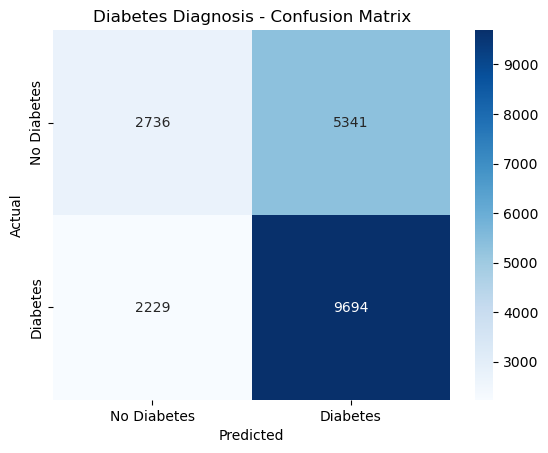

Accuracy: 0.6215
Precision: 0.6447622214832058
Recall: 0.813050406776818
F1 Score: 0.7191928184583426


In [15]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This model is worse still, but overfitting has been minimized. We will now look for a better threshold.

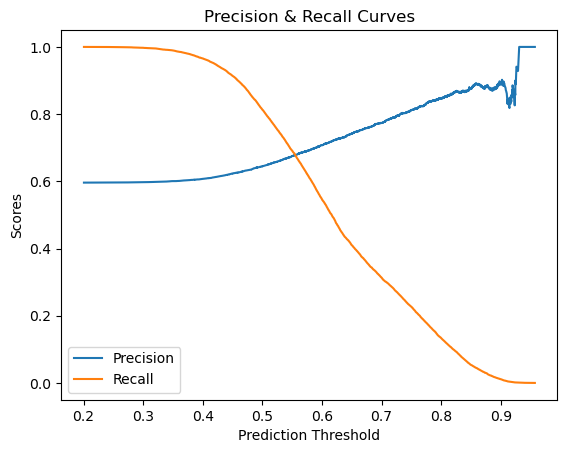

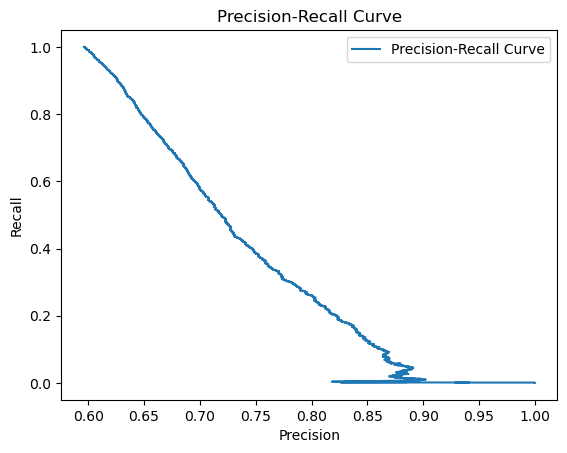

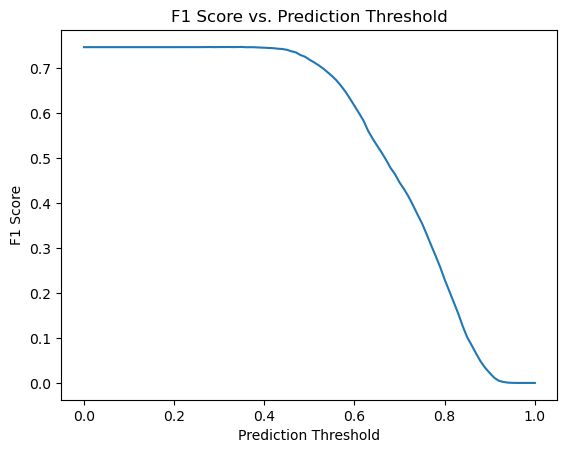

Best Threshold: 0.35000000000000003


In [18]:
y_test_proba = cat_3.predict_proba(X_test)[:, 1]
y_train_proba = cat_3.predict_proba(X_train)[:, 1]
best_threshold = optimize_threshold(y_test, y_test_proba)
print("Best Threshold:", best_threshold)

In [19]:
preds_train = y_train_proba >= best_threshold
preds_test = y_test_proba >= best_threshold

Training Set Metrics with Optimized Threshold:


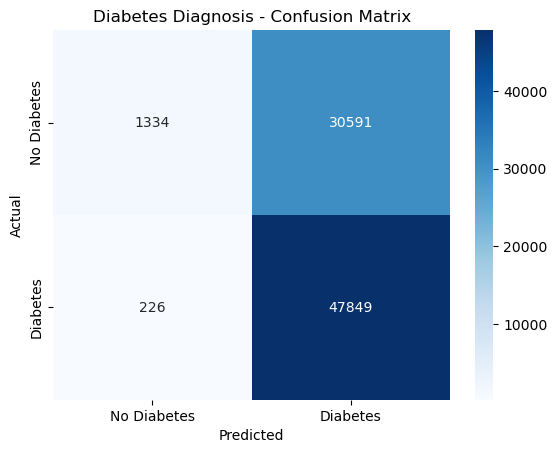

Accuracy: 0.6147875
Precision: 0.6100076491585925
Recall: 0.9952990119604784
F1 Score: 0.7564162352290242


Test Set Metrics with Optimized Threshold:


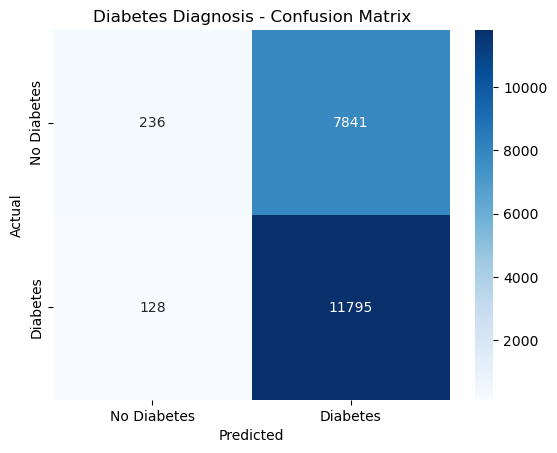

Accuracy: 0.60155
Precision: 0.6006824200448156
Recall: 0.9892644468673991
F1 Score: 0.7474888304445642


In [20]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

With an optimized threshold, our model virtually tells everyone that they have diabetes. It seems to be kind of useless. We will not save it for now, but we will plot the roc curve.

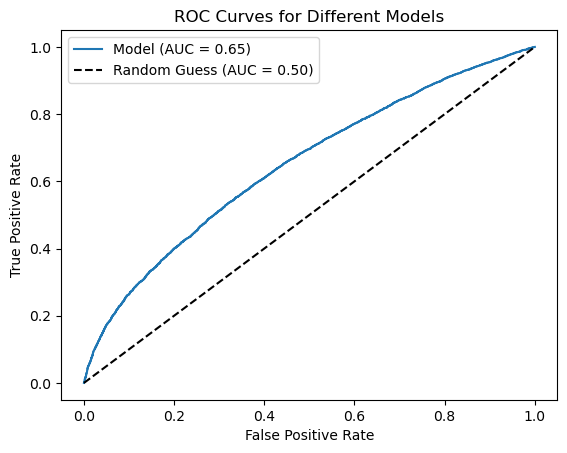

In [21]:
plot_roc_curve(y_test, y_test_proba)